### XGBoost 기본 설정


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import uniform, randint

df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')



# class_interval 범주화 함수
def convert_to_class_interval(value):
    if value < 0.1:
        return 0
    elif 0.1 <= value < 0.2:
        return 1
    elif 0.2 <= value < 0.5:
        return 2
    elif 0.5 <= value < 1.0:
        return 3
    elif 1.0 <= value < 2.0:
        return 4
    elif 2.0 <= value < 5.0:
        return 5
    elif 5.0 <= value < 10.0:
        return 6
    elif 10.0 <= value < 20.0:
        return 7
    elif 20.0 <= value < 30.0:
        return 8
    else:
        return 9



  # Hit, False Alarm, Miss 계산
def calculate_csi(y_true, y_pred):
    csi_matrix = np.zeros((10, 10))
    for yt, yp in zip(y_true, y_pred):
        csi_matrix[yt][yp] += 1

    hits = np.diag(csi_matrix).sum()
    false_alarms = csi_matrix.sum(axis=0) - np.diag(csi_matrix)
    misses = csi_matrix.sum(axis=1) - np.diag(csi_matrix)
    csi = hits / (hits + false_alarms.sum() + misses.sum())

    return csi

In [2]:
# 하이퍼파리미터 생성
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# RandomizedSearchCV 설정
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 하이퍼파라미터 튜닝 수행
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 최적의 하이퍼파라미터로 모델 학습
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = best_xgb.predict(X_train)
y_pred_test_best_xgb = best_xgb.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


KeyboardInterrupt: 

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')


df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 하이퍼파라미터 그리드 설정
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10]
}

# RandomizedSearchCV 설정
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# 하이퍼파라미터 튜닝 수행
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# 최적의 하이퍼파라미터로 모델 학습
best_xgb = random_search.best_estimator_
best_xgb.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = best_xgb.predict(X_train)
y_pred_test_best_xgb = best_xgb.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


### CSI: 0.35422490572210585

#### 기본 설정
- XGBoost 하이퍼파라미터 설정
- v01~x06만 사용 및 가중치 부여
- 계절 매핑

In [27]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=200,
    max_depth=12,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:25:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:25:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best XGBoost Regression
Train MSE: 3.9767471269978962, Train R2: 0.8016832278839092
Test MSE: 14.474117882355563, Test R2: 0.26197003106630434
CSI: 0.35422490572210585


In [19]:
df_train.columns

Index(['fc_day', 'fc_hour', 'dh', 'ef_year', 'ef_month', 'ef_day', 'ef_hour',
       'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'vv', 'season_autumn',
       'season_spring', 'season_summer', 'v01_w', 'v02_w', 'v03_w', 'v04_w',
       'v05_w', 'v06_w'],
      dtype='object')



### CSI: 0.34606450833646907

- 계절 변수 삭제


In [20]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)


# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=200,
    max_depth=12,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-20-e164cf597ac3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
<ipython-input-20-e164cf597ac3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ef_year'] = df_train['ef_year'].map(mapping)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:12:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CU

Best XGBoost Regression
Train MSE: 4.125945217798481, Train R2: 0.7942428544257678
Test MSE: 14.552875196044974, Test R2: 0.25795422449018435
CSI: 0.34606450833646907


### CSI : 0.35737708757875997
- stn 매핑 추가

In [22]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)


# STN 더미 변수 추가 - 원핫인코딩
stn_dummies = pd.get_dummies(df_train['stn4contest'], prefix='stn')
df_train = pd.concat([df_train, stn_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=200,
    max_depth=12,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-22-1fbede749d6b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
<ipython-input-22-1fbede749d6b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ef_year'] = df_train['ef_year'].map(mapping)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:14:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CU

Best XGBoost Regression
Train MSE: 3.198538381151945, Train R2: 0.8404917921652362
Test MSE: 11.981335666185046, Test R2: 0.38907608315957287
CSI: 0.35737708757875997


### CSI: 0.3952830449893639
- 두번째 하이퍼파라미터 사용
- stn 매핑



In [10]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)


# STN 더미 변수 추가 - 원핫인코딩
stn_dummies = pd.get_dummies(df_train['stn4contest'], prefix='stn')
df_train = pd.concat([df_train, stn_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=12,
    learning_rate=0.2,
    gamma=0.1,
    min_child_weight=10,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


Best XGBoost Regression
Train MSE: 1.7502279341733804, Train R2: 0.9127177204664987
Test MSE: 12.029567003590977, Test R2: 0.3866167849324441
CSI: 0.3952830449893639


### CSI: 0.35080940057330234
- 전체 변수 선택

In [24]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10
df_train['v07_w'] = df_train['v07']
df_train['v08_w'] = df_train['v08'] * 0.1
df_train['v09_w'] = df_train['v09'] * 0.01

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'season',  'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=200,
    max_depth=12,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:17:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:17:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best XGBoost Regression
Train MSE: 4.0264397190807335, Train R2: 0.799205103390389
Test MSE: 14.314208528926411, Test R2: 0.2701237504226591
CSI: 0.35080940057330234


### CSI: 0.35422490572210585

- 변수 가중치 추가 및 수정

In [28]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 1000
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05'] * 1000
df_train['fc_hour_w']=df_train['fc_hour'] *100
df_train['ef_year_w']=df_train['ef_year'] *100
df_train['v06_w'] = df_train['v06'] * 10


# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09',  'fc_year','fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=200,
    max_depth=12,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-28-a179f80c34a4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:26:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:26:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", 

Best XGBoost Regression
Train MSE: 3.9767471269978962, Train R2: 0.8016832278839092
Test MSE: 14.474117882355563, Test R2: 0.26197003106630434
CSI: 0.35422490572210585


### CSI: 0.3522364795019519

- 'v01', 'v02', 'v03', 'v04', 'v05','v06', train에서 변수 제거

In [31]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v01', 'v02', 'v03', 'v04', 'v05','v06','v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=200,
    max_depth=12,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")


# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])


# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-31-a1cb329ef652>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
<ipython-input-31-a1cb329ef652>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ef_year'] = df_train['ef_year'].map(mapping)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:41:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CU

Best XGBoost Regression
Train MSE: 4.155138729032507, Train R2: 0.7927870005004926
Test MSE: 14.528792790892027, Test R2: 0.25918217750751793
CSI: 0.3522364795019519


### CSI: 0.22303804147100723
- lightGBM 사용

In [39]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# LightGBM 모델 학습
lgb_model = lgb.LGBMRegressor()

lgb_model.fit(X_train, y_train)

# 예측
y_pred_train_lgb = lgb_model.predict(X_train)
y_pred_test_lgb = lgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_lgb = mean_squared_error(y_train, y_pred_train_lgb)
r2_train_lgb = r2_score(y_train, y_pred_train_lgb)

# 테스트 데이터 평가
mse_test_lgb = mean_squared_error(y_test, y_pred_test_lgb)
r2_test_lgb = r2_score(y_test, y_pred_test_lgb)

print("Best LightGBM Regression")
print(f"Train MSE: {mse_train_lgb}, Train R2: {r2_train_lgb}")
print(f"Test MSE: {mse_test_lgb}, Test R2: {r2_test_lgb}")



# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_lgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 1159009, number of used features: 22
[LightGBM] [Info] Start training from score 0.853976
Best LightGBM Regression
Train MSE: 14.414366604111661, Train R2: 0.27000228222853206
Test MSE: 14.397281985655482, Test R2: 0.2623088236998452
CSI: 0.22303804147100723


### CSI: 0.3981680417009973
- 두번째 하이퍼파라미터

-> 과적합문제 존재

In [27]:
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0','stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=12,
    learning_rate=0.2,
    gamma=0.1,
    min_child_weight=10,
    colsample_bytree=1.0,
    subsample=1.0,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-27-e7d6c9792180>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
<ipython-input-27-e7d6c9792180>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ef_year'] = df_train['ef_year'].map(mapping)


Best XGBoost Regression
Train MSE: 2.5073860848293026, Train R2: 0.8749589302733624
Test MSE: 15.182646594887636, Test R2: 0.22584241154925389
CSI: 0.3981680417009973


## CSI 두번째 하이퍼파라미터 적용 및 과적합 방지


### 기준 ===== CSI: 0.2567124836880886
- 과적합 방지

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-28-39645147b0df>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
<ipython-input-28-39645147b0df>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ef_year'] = df_train['ef_year'].map(mapping)


[0]	validation_0-rmse:4.34877
[1]	validation_0-rmse:4.28707
[2]	validation_0-rmse:4.22889
[3]	validation_0-rmse:4.18805


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:4.14403
[5]	validation_0-rmse:4.11727
[6]	validation_0-rmse:4.09401
[7]	validation_0-rmse:4.07090
[8]	validation_0-rmse:4.05171
[9]	validation_0-rmse:4.03514
[10]	validation_0-rmse:4.01506
[11]	validation_0-rmse:4.00674
[12]	validation_0-rmse:3.99325
[13]	validation_0-rmse:3.98592
[14]	validation_0-rmse:3.97379
[15]	validation_0-rmse:3.96663
[16]	validation_0-rmse:3.94824
[17]	validation_0-rmse:3.94052
[18]	validation_0-rmse:3.93611
[19]	validation_0-rmse:3.93224
[20]	validation_0-rmse:3.92870
[21]	validation_0-rmse:3.92642
[22]	validation_0-rmse:3.91822
[23]	validation_0-rmse:3.91602
[24]	validation_0-rmse:3.91287
[25]	validation_0-rmse:3.91040
[26]	validation_0-rmse:3.90679
[27]	validation_0-rmse:3.90442
[28]	validation_0-rmse:3.90039
[29]	validation_0-rmse:3.89907
[30]	validation_0-rmse:3.89663
[31]	validation_0-rmse:3.89666
[32]	validation_0-rmse:3.89605
[33]	validation_0-rmse:3.89611
[34]	validation_0-rmse:3.89358
[35]	validation_0-rmse:3.89401
[36]	validatio

### CSI: 0.25891634198346586
- 가중치 부여 삭제

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
# df_train['v01_w'] = df_train['v01'] * 100
# df_train['v02_w'] = df_train['v02'] * 1000
# df_train['v03_w'] = df_train['v03'] * 10000
# df_train['v04_w'] = df_train['v04'] * 10000
# df_train['v05_w'] = df_train['v05']
# df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-29-202d56f4ac2f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)


[0]	validation_0-rmse:4.35503
[1]	validation_0-rmse:4.29866
[2]	validation_0-rmse:4.24250


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:4.19142
[4]	validation_0-rmse:4.15948
[5]	validation_0-rmse:4.13355
[6]	validation_0-rmse:4.10095
[7]	validation_0-rmse:4.07305
[8]	validation_0-rmse:4.05780
[9]	validation_0-rmse:4.03525
[10]	validation_0-rmse:4.01952
[11]	validation_0-rmse:4.00889
[12]	validation_0-rmse:3.99326
[13]	validation_0-rmse:3.98661
[14]	validation_0-rmse:3.97521
[15]	validation_0-rmse:3.96494
[16]	validation_0-rmse:3.95880
[17]	validation_0-rmse:3.95173
[18]	validation_0-rmse:3.94607
[19]	validation_0-rmse:3.94179
[20]	validation_0-rmse:3.93861
[21]	validation_0-rmse:3.92929
[22]	validation_0-rmse:3.92451
[23]	validation_0-rmse:3.91845
[24]	validation_0-rmse:3.91497
[25]	validation_0-rmse:3.91189
[26]	validation_0-rmse:3.91034
[27]	validation_0-rmse:3.90963
[28]	validation_0-rmse:3.90590
[29]	validation_0-rmse:3.90508
[30]	validation_0-rmse:3.90462
[31]	validation_0-rmse:3.90158
[32]	validation_0-rmse:3.89984
[33]	validation_0-rmse:3.89083
[34]	validation_0-rmse:3.89069
[35]	validation

### CSI: 0.25055230451926713
- v07, v08, v09 변수 추가하였을 경우

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
# df_train['v01_w'] = df_train['v01'] * 100
# df_train['v02_w'] = df_train['v02'] * 1000
# df_train['v03_w'] = df_train['v03'] * 10000
# df_train['v04_w'] = df_train['v04'] * 10000
# df_train['v05_w'] = df_train['v05']
# df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-31-0153641906fa>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
<ipython-input-31-0153641906fa>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ef_year'] = df_train['ef_year'].map(mapping)


[0]	validation_0-rmse:4.36105
[1]	validation_0-rmse:4.30379
[2]	validation_0-rmse:4.25661
[3]	validation_0-rmse:4.20496


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:4.16955
[5]	validation_0-rmse:4.13630
[6]	validation_0-rmse:4.11640
[7]	validation_0-rmse:4.08880
[8]	validation_0-rmse:4.06554
[9]	validation_0-rmse:4.04473
[10]	validation_0-rmse:4.02647
[11]	validation_0-rmse:4.01425
[12]	validation_0-rmse:4.00170
[13]	validation_0-rmse:3.98880
[14]	validation_0-rmse:3.97296
[15]	validation_0-rmse:3.96659
[16]	validation_0-rmse:3.95880
[17]	validation_0-rmse:3.95555
[18]	validation_0-rmse:3.95297
[19]	validation_0-rmse:3.94757
[20]	validation_0-rmse:3.93881
[21]	validation_0-rmse:3.93682
[22]	validation_0-rmse:3.93384
[23]	validation_0-rmse:3.92764
[24]	validation_0-rmse:3.92325
[25]	validation_0-rmse:3.91845
[26]	validation_0-rmse:3.91446
[27]	validation_0-rmse:3.91279
[28]	validation_0-rmse:3.90970
[29]	validation_0-rmse:3.90959
[30]	validation_0-rmse:3.90843
[31]	validation_0-rmse:3.90817
[32]	validation_0-rmse:3.90209
[33]	validation_0-rmse:3.90189
[34]	validation_0-rmse:3.89888
[35]	validation_0-rmse:3.89534
[36]	validatio

### CSI: 0.24978635738944635
- 계절 매핑 삭제

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

# df_train['fc_datetime'] = pd.to_datetime(
#     df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
#     .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
# )
# df_train['ef_datetime'] = pd.to_datetime(
#     df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
#     .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
# )

# # 계절 매핑 함수
# def get_season(month):
#     if month in [3, 4, 5]:
#         return 'spring'
#     elif month in [6, 7, 8]:
#         return 'summer'
#     elif month in [9, 10, 11]:
#         return 'autumn'
#     else:
#         return 'winter'

# # fc_month를 계절로 변환하여 season 컬럼 추가
# df_train['season'] = df_train['fc_month'].apply(get_season)

# # 계절을 더미 변수로 변환 (One-Hot Encoding)
# season_dummies = pd.get_dummies(df_train['season'], prefix='season')
# df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
# df_train['v01_w'] = df_train['v01'] * 100
# df_train['v02_w'] = df_train['v02'] * 1000
# df_train['v03_w'] = df_train['v03'] * 10000
# df_train['v04_w'] = df_train['v04'] * 10000
# df_train['v05_w'] = df_train['v05']
# df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest','fc_year', 'v07','v08','v09','fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


[0]	validation_0-rmse:4.35139
[1]	validation_0-rmse:4.28889
[2]	validation_0-rmse:4.23413


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:4.19519
[4]	validation_0-rmse:4.15532
[5]	validation_0-rmse:4.12315
[6]	validation_0-rmse:4.09356
[7]	validation_0-rmse:4.06611
[8]	validation_0-rmse:4.04192
[9]	validation_0-rmse:4.02924
[10]	validation_0-rmse:4.01404
[11]	validation_0-rmse:4.00593
[12]	validation_0-rmse:3.99526
[13]	validation_0-rmse:3.98606
[14]	validation_0-rmse:3.97108
[15]	validation_0-rmse:3.96051
[16]	validation_0-rmse:3.95712
[17]	validation_0-rmse:3.95183
[18]	validation_0-rmse:3.94801
[19]	validation_0-rmse:3.94078
[20]	validation_0-rmse:3.93545
[21]	validation_0-rmse:3.91867
[22]	validation_0-rmse:3.91476
[23]	validation_0-rmse:3.91043
[24]	validation_0-rmse:3.90771
[25]	validation_0-rmse:3.90641
[26]	validation_0-rmse:3.90248
[27]	validation_0-rmse:3.89969
[28]	validation_0-rmse:3.89826
[29]	validation_0-rmse:3.89556
[30]	validation_0-rmse:3.89416
[31]	validation_0-rmse:3.89233
[32]	validation_0-rmse:3.88667
[33]	validation_0-rmse:3.88119
[34]	validation_0-rmse:3.87689
[35]	validation

### CSI: 0.24444420584153606
- fc_year, fc_month 변수 추가

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# #가중치 부여
# df_train['v01_w'] = df_train['v01'] * 100
# df_train['v02_w'] = df_train['v02'] * 1000
# df_train['v03_w'] = df_train['v03'] * 10000
# df_train['v04_w'] = df_train['v04'] * 10000
# df_train['v05_w'] = df_train['v05']
# df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest','class_interval','season','fc_datetime','ef_datetime'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


[0]	validation_0-rmse:4.35396
[1]	validation_0-rmse:4.28948
[2]	validation_0-rmse:4.23115
[3]	validation_0-rmse:4.18208


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:4.14602
[5]	validation_0-rmse:4.11264
[6]	validation_0-rmse:4.08903
[7]	validation_0-rmse:4.06590
[8]	validation_0-rmse:4.04097
[9]	validation_0-rmse:4.02637
[10]	validation_0-rmse:4.01293
[11]	validation_0-rmse:4.00138
[12]	validation_0-rmse:3.98901
[13]	validation_0-rmse:3.97574
[14]	validation_0-rmse:3.96301
[15]	validation_0-rmse:3.95650
[16]	validation_0-rmse:3.94351
[17]	validation_0-rmse:3.93883
[18]	validation_0-rmse:3.93289
[19]	validation_0-rmse:3.92496
[20]	validation_0-rmse:3.92131
[21]	validation_0-rmse:3.91953
[22]	validation_0-rmse:3.91763
[23]	validation_0-rmse:3.91668
[24]	validation_0-rmse:3.90898
[25]	validation_0-rmse:3.90615
[26]	validation_0-rmse:3.90178
[27]	validation_0-rmse:3.89882
[28]	validation_0-rmse:3.89644
[29]	validation_0-rmse:3.89404
[30]	validation_0-rmse:3.88910
[31]	validation_0-rmse:3.88770
[32]	validation_0-rmse:3.88751
[33]	validation_0-rmse:3.88577
[34]	validation_0-rmse:3.88405
[35]	validation_0-rmse:3.88352
[36]	validatio

### CSI: 0.25502710358702924
- 월별 vv 변수 추가

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
df_train['v01_w'] = df_train['v01'] * 100
df_train['v02_w'] = df_train['v02'] * 1000
df_train['v03_w'] = df_train['v03'] * 10000
df_train['v04_w'] = df_train['v04'] * 10000
df_train['v05_w'] = df_train['v05']
df_train['v06_w'] = df_train['v06'] * 10

# 월별 vv 추가
df_train['fc_month'] = df_train['fc_month']
monthly_vv = df_train.groupby('fc_month')['vv'].mean().rename('monthly_vv')
df_train = df_train.merge(monthly_vv, on='fc_month', how='left')

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


[0]	validation_0-rmse:4.35746
[1]	validation_0-rmse:4.28783
[2]	validation_0-rmse:4.23051
[3]	validation_0-rmse:4.18796


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:4.14320
[5]	validation_0-rmse:4.10697
[6]	validation_0-rmse:4.08241
[7]	validation_0-rmse:4.05791
[8]	validation_0-rmse:4.03756
[9]	validation_0-rmse:4.02560
[10]	validation_0-rmse:4.01401
[11]	validation_0-rmse:3.99726
[12]	validation_0-rmse:3.98515
[13]	validation_0-rmse:3.97398
[14]	validation_0-rmse:3.95831
[15]	validation_0-rmse:3.94795
[16]	validation_0-rmse:3.94478
[17]	validation_0-rmse:3.93869
[18]	validation_0-rmse:3.93637
[19]	validation_0-rmse:3.93057
[20]	validation_0-rmse:3.92687
[21]	validation_0-rmse:3.92216
[22]	validation_0-rmse:3.91899
[23]	validation_0-rmse:3.91834
[24]	validation_0-rmse:3.91365
[25]	validation_0-rmse:3.90979
[26]	validation_0-rmse:3.90116
[27]	validation_0-rmse:3.90068
[28]	validation_0-rmse:3.89963
[29]	validation_0-rmse:3.89956
[30]	validation_0-rmse:3.89341
[31]	validation_0-rmse:3.88923
[32]	validation_0-rmse:3.87930
[33]	validation_0-rmse:3.87886
[34]	validation_0-rmse:3.87663
[35]	validation_0-rmse:3.87611
[36]	validatio

### CSI: 0.2598181268763954
- 가중치 부여 삭제
- 월별 vv 변수 추가

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# # 가중치 부여
# df_train['v01_w'] = df_train['v01'] * 100
# df_train['v02_w'] = df_train['v02'] * 1000
# df_train['v03_w'] = df_train['v03'] * 10000
# df_train['v04_w'] = df_train['v04'] * 10000
# df_train['v05_w'] = df_train['v05']
# df_train['v06_w'] = df_train['v06'] * 10

# 월별 vv 추가
df_train['fc_month'] = df_train['fc_month']
monthly_vv = df_train.groupby('fc_month')['vv'].mean().rename('monthly_vv')
df_train = df_train.merge(monthly_vv, on='fc_month', how='left')

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-44-2104dee9ec35>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
<ipython-input-44-2104dee9ec35>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['ef_year'] = df_train['ef_year'].map(mapping)


[0]	validation_0-rmse:4.35725
[1]	validation_0-rmse:4.30019
[2]	validation_0-rmse:4.24605
[3]	validation_0-rmse:4.19550


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[4]	validation_0-rmse:4.15783
[5]	validation_0-rmse:4.11862
[6]	validation_0-rmse:4.09631
[7]	validation_0-rmse:4.06961
[8]	validation_0-rmse:4.04882
[9]	validation_0-rmse:4.02425
[10]	validation_0-rmse:4.00164
[11]	validation_0-rmse:3.98754
[12]	validation_0-rmse:3.97805
[13]	validation_0-rmse:3.96815
[14]	validation_0-rmse:3.95473
[15]	validation_0-rmse:3.94624
[16]	validation_0-rmse:3.93818
[17]	validation_0-rmse:3.92691
[18]	validation_0-rmse:3.91884
[19]	validation_0-rmse:3.91350
[20]	validation_0-rmse:3.91130
[21]	validation_0-rmse:3.90587
[22]	validation_0-rmse:3.90295
[23]	validation_0-rmse:3.89519
[24]	validation_0-rmse:3.89267
[25]	validation_0-rmse:3.89118
[26]	validation_0-rmse:3.88495
[27]	validation_0-rmse:3.88308
[28]	validation_0-rmse:3.88022
[29]	validation_0-rmse:3.87951
[30]	validation_0-rmse:3.87479
[31]	validation_0-rmse:3.87411
[32]	validation_0-rmse:3.87148
[33]	validation_0-rmse:3.86743
[34]	validation_0-rmse:3.86523
[35]	validation_0-rmse:3.86382
[36]	validatio

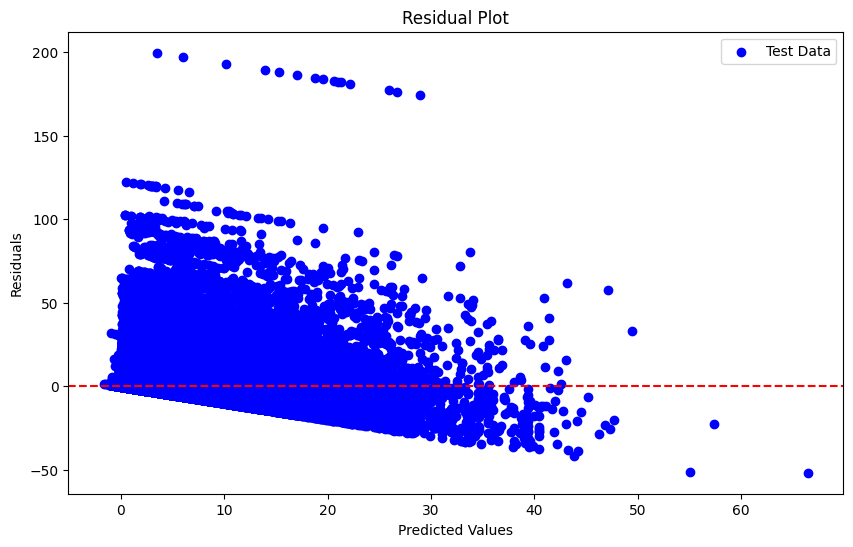

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 잔차 플롯
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test_best_xgb, y_test - y_pred_test_best_xgb, c='blue', marker='o', label='Test Data')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend(loc='upper right')
plt.show()

# 이분산성 문제
# 이상치 문제
# 일정한 방향으로 잔차가 분포됨

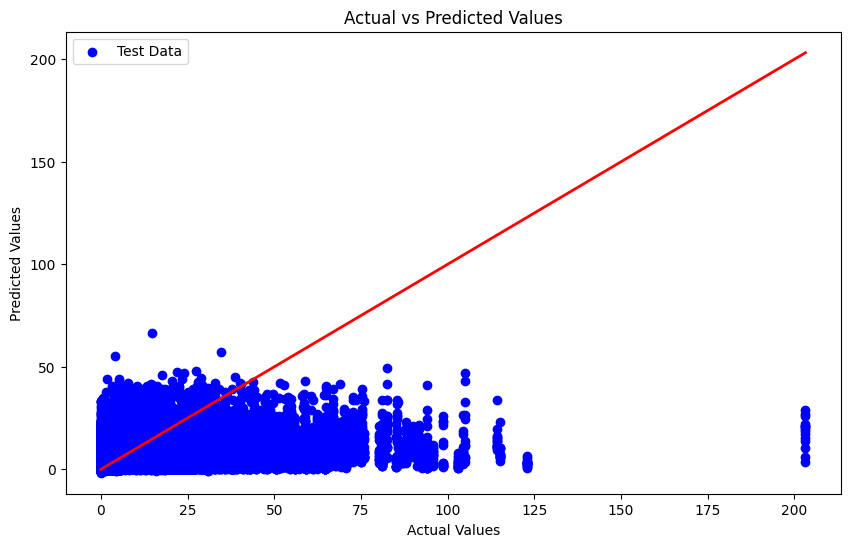

In [47]:
# 2. 예측값 vs 실제값 플롯
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_best_xgb, c='blue', marker='o', label='Test Data')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], lw=2, color='r')
plt.legend(loc='upper left')
plt.show()

#대각선을 따라 파란점이 분포되어 있어야 하는데 그렇지 않음

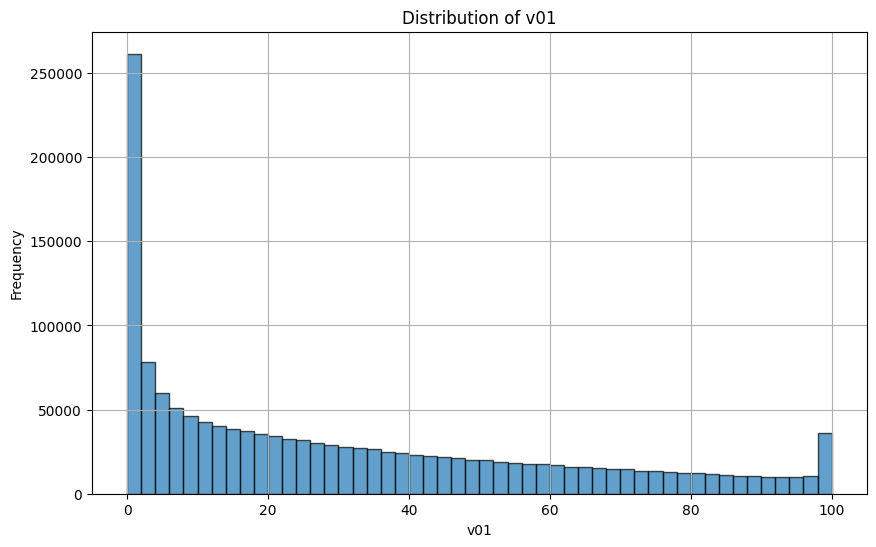

In [4]:
import matplotlib.pyplot as plt
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')

# v01 변수의 분포 확인
plt.figure(figsize=(10, 6))
plt.hist(df_train['rainfall_train.v01'], bins=50, edgecolor='k', alpha=0.7)
plt.title('Distribution of v01')
plt.xlabel('v01')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

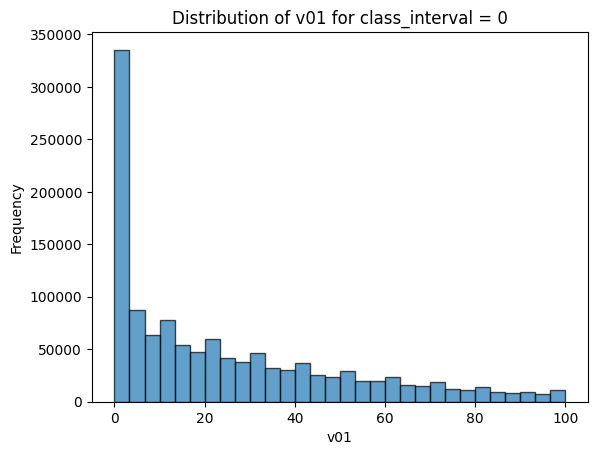

count    1.223315e+06
mean     2.474727e+01
std      2.579190e+01
min      0.000000e+00
25%      2.000000e+00
50%      1.600000e+01
75%      4.000000e+01
max      1.000000e+02
Name: rainfall_train.v01, dtype: float64


In [5]:
# 'class_interval'이 0인 행 필터링
class_interval_0 = df_train[df_train['rainfall_train.class_interval'] == 0]

# 'v01' 값 분포 시각화
plt.hist(class_interval_0['rainfall_train.v01'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('v01')
plt.ylabel('Frequency')
plt.title('Distribution of v01 for class_interval = 0')
plt.show()

class_interval_0['rainfall_train.v01'].describe()


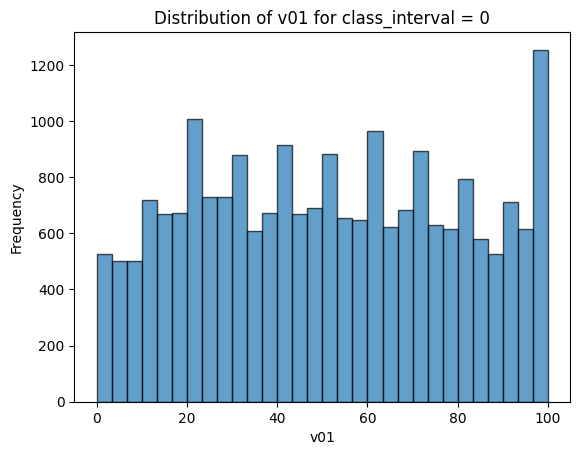

count    21562.000000
mean        51.299323
std         28.515805
min          0.000000
25%         27.000000
50%         51.000000
75%         75.000000
max        100.000000
Name: rainfall_train.v01, dtype: float64

In [6]:
# 'class_interval'이 1인 행 필터링
class_interval_0 = df_train[df_train['rainfall_train.class_interval'] == 1]

# 'v01' 값 분포 시각화
plt.hist(class_interval_0['rainfall_train.v01'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('v01')
plt.ylabel('Frequency')
plt.title('Distribution of v01 for class_interval = 0')
plt.show()

class_interval_0['rainfall_train.v01'].describe()


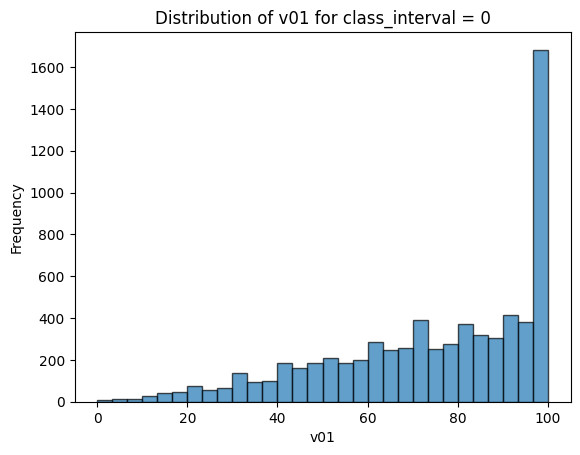

count    6986.000000
mean       74.430575
std        23.437762
min         0.000000
25%        59.000000
50%        79.000000
75%        96.000000
max       100.000000
Name: rainfall_train.v01, dtype: float64

In [8]:
# 'class_interval'이 1인 행 필터링
class_interval_0 = df_train[df_train['rainfall_train.class_interval'] == 9]

# 'v01' 값 분포 시각화
plt.hist(class_interval_0['rainfall_train.v01'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('v01')
plt.ylabel('Frequency')
plt.title('Distribution of v01 for class_interval = 0')
plt.show()

class_interval_0['rainfall_train.v01'].describe()


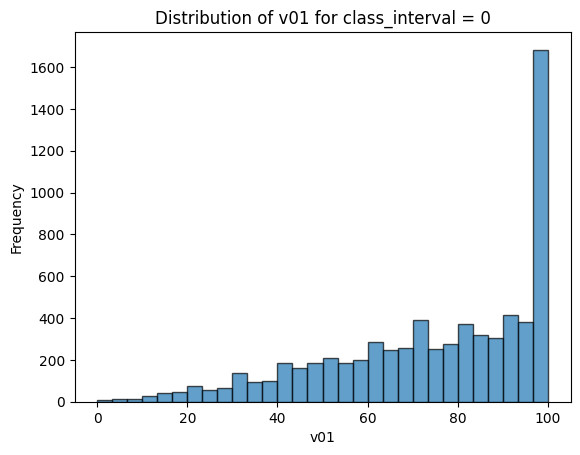

count    27964.000000
mean        65.792412
std         27.380251
min          0.000000
25%         44.000000
50%         69.000000
75%         91.000000
max        100.000000
Name: rainfall_train.v01, dtype: float64

In [18]:
# 'class_interval'이 1인 행 필터링
class_interval_6 = df_train[df_train['rainfall_train.class_interval'] == 6]

# 'v01' 값 분포 시각화
plt.hist(class_interval_0['rainfall_train.v01'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('v01')
plt.ylabel('Frequency')
plt.title('Distribution of v01 for class_interval = 0')
plt.show()

class_interval_6['rainfall_train.v01'].describe()

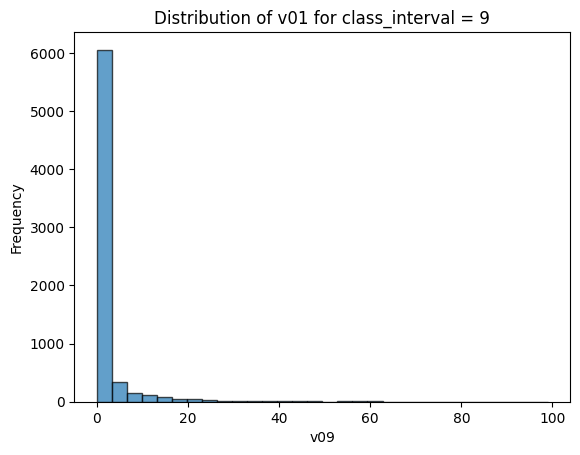

count    6986.000000
mean        2.408674
std         8.044171
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        99.000000
Name: rainfall_train.v09, dtype: float64

In [17]:
# 'class_interval'이 1인 행 필터링
class_interval_9 = df_train[df_train['rainfall_train.class_interval'] == 9]

# 'v01' 값 분포 시각화
plt.hist(class_interval_0['rainfall_train.v09'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('v09')
plt.ylabel('Frequency')
plt.title('Distribution of v01 for class_interval = 9')
plt.show()

class_interval_9['rainfall_train.v09'].describe()

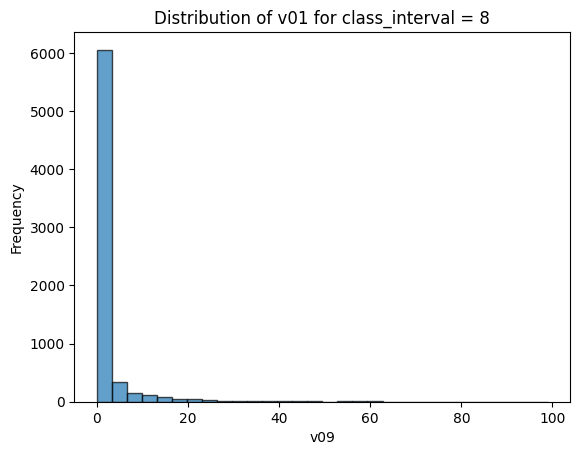

count    8187.000000
mean        1.618786
std         5.580270
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        79.000000
Name: rainfall_train.v09, dtype: float64

In [21]:
# 'class_interval'이 1인 행 필터링
class_interval_8 = df_train[df_train['rainfall_train.class_interval'] == 8]

# 'v01' 값 분포 시각화
plt.hist(class_interval_0['rainfall_train.v09'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('v09')
plt.ylabel('Frequency')
plt.title('Distribution of v01 for class_interval = 8')
plt.show()

class_interval_8['rainfall_train.v09'].describe()

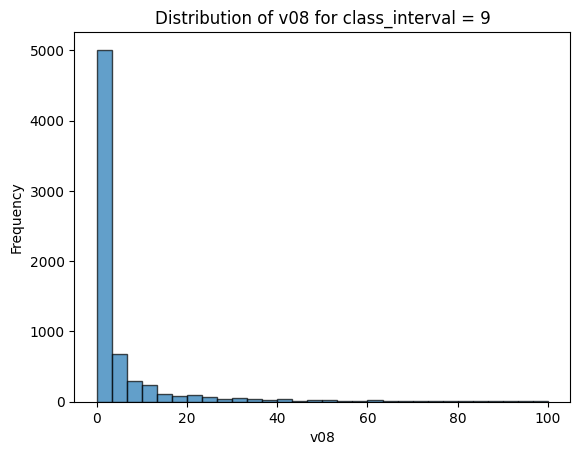

count    6986.000000
mean        5.660464
std        13.464929
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max       100.000000
Name: rainfall_train.v08, dtype: float64

In [20]:
# 'class_interval'이 1인 행 필터링
class_interval_9 = df_train[df_train['rainfall_train.class_interval'] == 9]

# 'v01' 값 분포 시각화
plt.hist(class_interval_0['rainfall_train.v08'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('v08')
plt.ylabel('Frequency')
plt.title('Distribution of v08 for class_interval = 9')
plt.show()

class_interval_9['rainfall_train.v08'].describe()

### CSI: 0.730684517898767


- v09가 2보다 클 경우는 vv을 30으로 설정, v01이 25보다 작을 경우는 vv를 0.05로 저장
- 월별 변수 제거 (실제 test할 때는 vv가 없어서 해당 컬럼 활용 못함)

- 문제점 :
  - Train MSE: 20.6993880271844,
  - Train R2: -0.032259705541955785
  - Test MSE: 20.261677072335655,
  - Test R2: -0.03313549204055821

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# # 월별 vv 추가
# df_train['fc_month'] = df_train['fc_month']
# monthly_vv = df_train.groupby('fc_month')['vv'].mean().rename('monthly_vv')
# df_train = df_train.merge(monthly_vv, on='fc_month', how='left')

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08',  'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)




/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:56:43] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:4.36026
[1]	validation_0-rmse:4.29650
[2]	validation_0-rmse:4.24176
[3]	validation_0-rmse:4.20020
[4]	validation_0-rmse:4.16091
[5]	validation_0-rmse:4.13439
[6]	validation_0-rmse:4.10127
[7]	validation_0-rmse:4.07512
[8]	validation_0-rmse:4.05177
[9]	validation_0-rmse:4.03353
[10]	validation_0-rmse:4.01710
[11]	validation_0-rmse:4.00585
[12]	validation_0-rmse:3.99697
[13]	validation_0-rmse:3.98660
[14]	validation_0-rmse:3.96953
[15]	validation_0-rmse:3.96160
[16]	validation_0-rmse:3.95082
[17]	validation_0-rmse:3.94286
[18]	validation_0-rmse:3.93927
[19]	validation_0-rmse:3.93472
[20]	validation_0-rmse:3.92610
[21]	validation_0-rmse:3.92335
[22]	validation_0-rmse:3.91686
[23]	validation_0-rmse:3.91041
[24]	validation_0-rmse:3.90515
[25]	validation_0-rmse:3.89629
[26]	validation_0-rmse:3.89425
[27]	validation_0-rmse:3.89398
[28]	validation_0-rmse:3.89201
[29]	validation_0-rmse:3.88885
[30]	validation_0-rmse:3.88880
[31]	validation_0-rmse:3.88613
[32]	validation_0-

In [40]:
# 추가적인 조건 적용
v09_index = df_train.columns.get_loc('v09')
v01_index = df_train.columns.get_loc('v01')

y_pred_train_best_xgb = np.where((X_train[:, v09_index] > 2), 30, y_pred_train_best_xgb)
y_pred_test_best_xgb = np.where((X_test[:, v09_index] > 2), 30, y_pred_test_best_xgb)
y_pred_train_best_xgb = np.where((X_train[:, v01_index] < 25), 0.05, y_pred_train_best_xgb)
y_pred_test_best_xgb = np.where((X_test[:, v01_index] < 25), 0.05, y_pred_test_best_xgb)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")

Best XGBoost Regression
Train MSE: 20.6993880271844, Train R2: -0.032259705541955785
Test MSE: 20.261677072335655, Test R2: -0.03313549204055821
CSI: 0.730684517898767


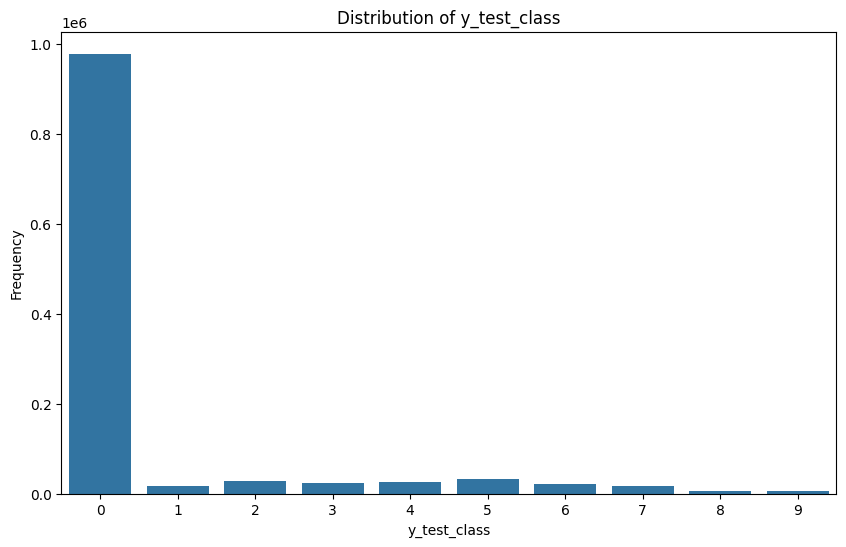

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_test_class)
plt.xlabel('y_test_class')
plt.ylabel('Frequency')
plt.title('Distribution of y_test_class')
plt.show()


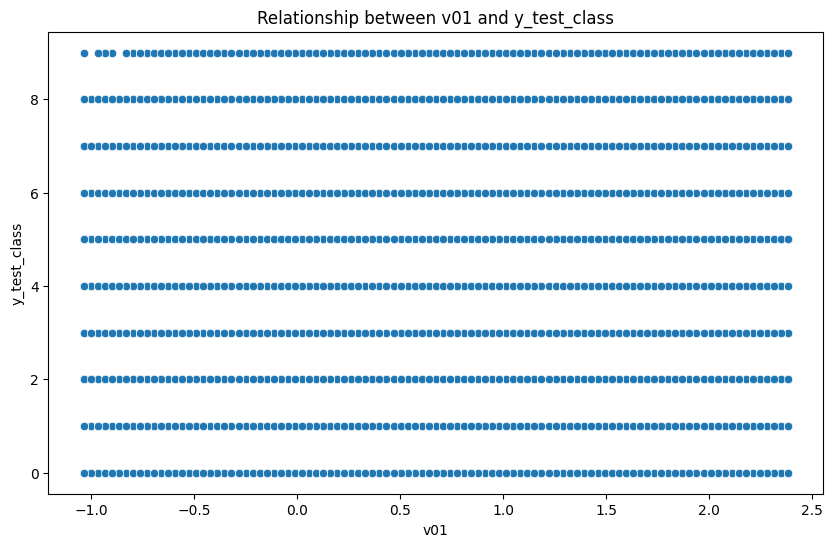

In [31]:
y_test_class_df = pd.DataFrame(y_test_class, columns=['y_test_class'])
X_test_df = pd.DataFrame(X_test, columns=df_train.drop(columns=['vv']).columns)

# v01 변수 추가
y_test_class_df['v01'] = X_test_df['v01']

# 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='v01', y='y_test_class', data=y_test_class_df)
plt.xlabel('v01')
plt.ylabel('y_test_class')
plt.title('Relationship between v01 and y_test_class')
plt.show()

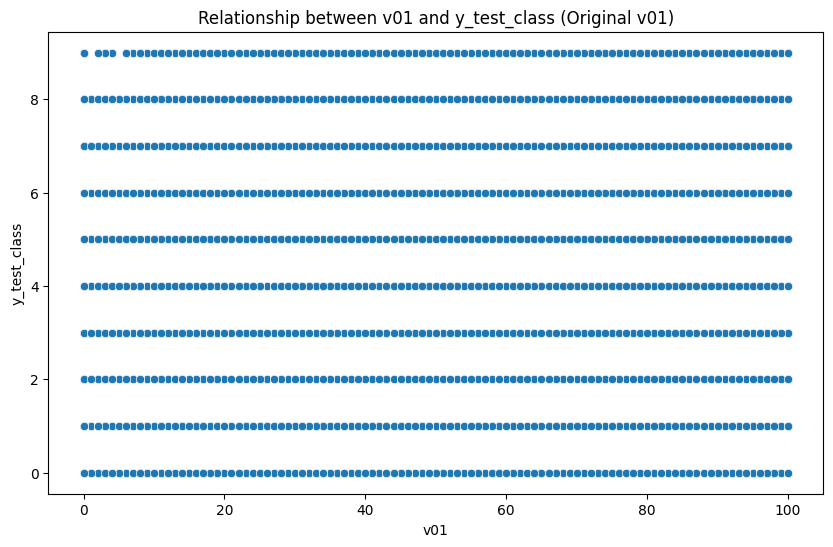

In [32]:
X_original = df_train.drop(columns=['vv']).values
X_train_original, X_test_original, _, _ = train_test_split(X_original, y, test_size=0.8, random_state=42)

# v01 값 추출
v01_test = X_test_original[:, v01_index]

# y_test_class와 v01 관계 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=v01_test, y=y_test_class)
plt.xlabel('v01')
plt.ylabel('y_test_class')
plt.title('Relationship between v01 and y_test_class (Original v01)')
plt.show()

## 실제 test 데이터에 모델링

In [50]:
df_test = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_test.csv')
df_test.columns = df_test.columns.str.replace('rainfall_test.', '', regex=False)

mapping2 = {'D': 2024}
df_test['fc_year'] = df_test['fc_year'].map(mapping2)
df_test['ef_year'] = df_test['ef_year'].map(mapping2)

df_test['fc_datetime'] = pd.to_datetime(
    df_test[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_test['ef_datetime'] = pd.to_datetime(
    df_test[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)
df_test

,Unnamed: 0,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,...,v03,v04,v05,v06,v07,v08,v09,class_interval,fc_datetime,ef_datetime
0,1,2024,5,1,9,STN031,3,2024,5,1,...,13,1,0,0,0,0,0,NaN,2024-05-01 09:00:00,2024-05-01 12:00:00
1,2,2024,5,1,9,STN031,6,2024,5,1,...,26,5,0,0,0,0,0,NaN,2024-05-01 09:00:00,2024-05-01 15:00:00
2,3,2024,5,1,9,STN031,9,2024,5,1,...,0,0,0,0,0,0,0,NaN,2024-05-01 09:00:00,2024-05-01 18:00:00
3,4,2024,5,1,9,STN031,12,2024,5,1,...,0,0,0,0,0,0,0,NaN,2024-05-01 09:00:00,2024-05-01 21:00:00
4,5,2024,5,1,9,STN031,15,2024,5,2,...,0,0,0,0,0,0,0,NaN,2024-05-01 09:00:00,2024-05-02 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,121996,2024,9,30,21,STN035,228,2024,10,10,...,4,2,2,0,0,0,0,NaN,2024-09-30 21:00:00,2024-10-10 09:00:00
121996,121997,2024,9,30,21,STN035,231,2024,10,10,...,6,5,0,0,0,0,0,NaN,2024-09-30 21:00:00,2024-10-10 12:00:00
121997,121998,2024,9,30,21,STN035,234,2024,10,10,...,6,5,0,0,0,0,0,NaN,2024-09-30 21:00:00,2024-10-10 15:00:00
121998,121999,2024,9,30,21,STN035,237,2024,10,10,...,8,8,6,2,0,0,0,NaN,2024-09-30 21:00:00,2024-10-10 18:00:00


In [51]:

df_test['season'] = df_test['fc_month'].apply(get_season)
season_dummies_test = pd.get_dummies(df_test['season'], prefix='season')
df_test = pd.concat([df_test, season_dummies_test], axis=1)

# 필요 없는 컬럼 제거
df_test = df_test.drop(columns=['Unnamed: 0', 'stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08',  'fc_year', 'fc_month','class_interval'])


In [52]:
df_test

,fc_day,fc_hour,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,v09,season_autumn,season_spring,season_summer
0,1,9,3,2024,5,1,12,68,46,13,1,0,0,0,False,True,False
1,1,9,6,2024,5,1,15,83,66,26,5,0,0,0,False,True,False
2,1,9,9,2024,5,1,18,17,6,0,0,0,0,0,False,True,False
3,1,9,12,2024,5,1,21,0,0,0,0,0,0,0,False,True,False
4,1,9,15,2024,5,2,0,0,0,0,0,0,0,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,30,21,228,2024,10,10,9,4,4,4,2,2,0,0,True,False,False
121996,30,21,231,2024,10,10,12,8,6,6,5,0,0,0,True,False,False
121997,30,21,234,2024,10,10,15,8,6,6,5,0,0,0,True,False,False
121998,30,21,237,2024,10,10,18,10,8,8,8,6,2,0,True,False,False


In [49]:
X

,fc_day,fc_hour,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,v09,season_autumn,season_spring,season_summer
0,1,9,3,2021,5,1,12,0,0,0,0,0,0,0,False,True,False
1,1,9,6,2021,5,1,15,0,0,0,0,0,0,0,False,True,False
2,1,9,9,2021,5,1,18,0,0,0,0,0,0,0,False,True,False
3,1,9,12,2021,5,1,21,0,0,0,0,0,0,0,False,True,False
4,1,9,15,2021,5,2,0,0,0,0,0,0,0,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457247,30,21,228,2023,10,10,9,9,7,2,2,0,0,0,True,False,False
1457248,30,21,231,2023,10,10,12,13,9,5,3,1,0,0,True,False,False
1457249,30,21,234,2023,10,10,15,13,9,5,3,1,0,0,True,False,False
1457250,30,21,237,2023,10,10,18,8,6,4,2,2,0,0,True,False,False


In [53]:
X_test_real = df_test

# 스케일링 적용
X_test_real_scaled = scaler.transform(X_test_real)

# 예측
y_pred_test_real = xgb_model.predict(X_test_real_scaled)

# 추가적인 조건 적용
y_pred_test_real = np.where((X_test_real_scaled[:, v09_index] > 2), 30, y_pred_test_real)
y_pred_test_real = np.where((X_test_real_scaled[:, v01_index] < 25), 0.05, y_pred_test_real)

# 결과 저장
df_test['predicted_vv'] = y_pred_test_real


In [55]:
df_test['class_interval'] = np.array([convert_to_class_interval(value) for value in y_pred_test_real])


In [57]:
df_test

,fc_day,fc_hour,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,v09,season_autumn,season_spring,season_summer,predicted_vv,class_interval
0,1,9,3,2024,5,1,12,68,46,13,1,0,0,0,False,True,False,0.05,0
1,1,9,6,2024,5,1,15,83,66,26,5,0,0,0,False,True,False,0.05,0
2,1,9,9,2024,5,1,18,17,6,0,0,0,0,0,False,True,False,0.05,0
3,1,9,12,2024,5,1,21,0,0,0,0,0,0,0,False,True,False,0.05,0
4,1,9,15,2024,5,2,0,0,0,0,0,0,0,0,False,True,False,0.05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,30,21,228,2024,10,10,9,4,4,4,2,2,0,0,True,False,False,0.05,0
121996,30,21,231,2024,10,10,12,8,6,6,5,0,0,0,True,False,False,0.05,0
121997,30,21,234,2024,10,10,15,8,6,6,5,0,0,0,True,False,False,0.05,0
121998,30,21,237,2024,10,10,18,10,8,8,8,6,2,0,True,False,False,0.05,0


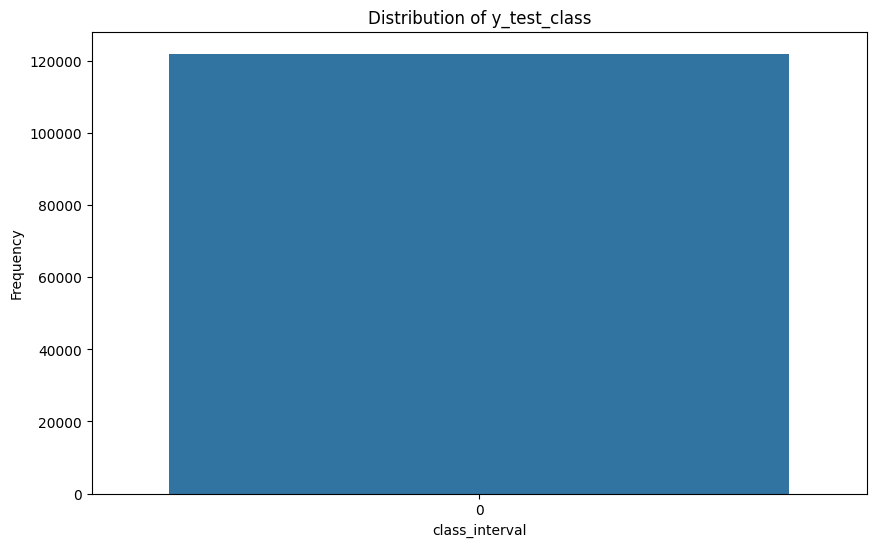

In [59]:
plt.figure(figsize=(10, 6))
sns.countplot(x='class_interval', data=df_test)
plt.xlabel('class_interval')
plt.ylabel('Frequency')
plt.title('Distribution of y_test_class')
plt.show()


## 다시 두번째 하이퍼파라미터 적용으로 시작

### CSI: 0.2539700142544542

In [116]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# 가중치 부여
# df_train['v01_w'] = df_train['v01'] * 100
# df_train['v02_w'] = df_train['v02'] * 1000
# df_train['v03_w'] = df_train['v03'] * 10000
# df_train['v04_w'] = df_train['v04'] * 10000
# df_train['v05_w'] = df_train['v05']
# df_train['v06_w'] = df_train['v06'] * 10

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['Unnamed: 0', 'stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


<ipython-input-116-202d56f4ac2f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['fc_year'] = df_train['fc_year'].map(mapping)
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:12:12] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:4.36306
[1]	validation_0-rmse:4.30054
[2]	validation_0-rmse:4.24650
[3]	validation_0-rmse:4.20783
[4]	validation_0-rmse:4.17703
[5]	validation_0-rmse:4.13905
[6]	validation_0-rmse:4.10910
[7]	validation_0-rmse:4.08974
[8]	validation_0-rmse:4.06560
[9]	validation_0-rmse:4.04630
[10]	validation_0-rmse:4.03339
[11]	validation_0-rmse:4.01815
[12]	validation_0-rmse:4.00903
[13]	validation_0-rmse:3.99633
[14]	validation_0-rmse:3.98283
[15]	validation_0-rmse:3.97493
[16]	validation_0-rmse:3.96782
[17]	validation_0-rmse:3.95998
[18]	validation_0-rmse:3.95529
[19]	validation_0-rmse:3.94852
[20]	validation_0-rmse:3.94426
[21]	validation_0-rmse:3.93894
[22]	validation_0-rmse:3.93483
[23]	validation_0-rmse:3.93077
[24]	validation_0-rmse:3.92656
[25]	validation_0-rmse:3.92393
[26]	validation_0-rmse:3.92344
[27]	validation_0-rmse:3.92031
[28]	validation_0-rmse:3.91913
[29]	validation_0-rmse:3.91790
[30]	validation_0-rmse:3.91608
[31]	validation_0-rmse:3.91416
[32]	validation_0-

In [117]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

df_test = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_test.csv')
df_test.columns = df_test.columns.str.replace('rainfall_test.', '', regex=False)

mapping2 = {'D': 2024}
df_test['fc_year'] = df_test['fc_year'].map(mapping2)
df_test['ef_year'] = df_test['ef_year'].map(mapping2)

df_test['fc_datetime'] = pd.to_datetime(
    df_test[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_test['ef_datetime'] = pd.to_datetime(
    df_test[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

df_test['season'] = df_test['fc_month'].apply(get_season)
season_dummies_test = pd.get_dummies(df_test['season'], prefix='season')
df_test = pd.concat([df_test, season_dummies_test], axis=1)

df_test = df_test.drop(columns=['stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month','class_interval'])

scaler = StandardScaler()
X_test_real_scaled = scaler.fit_transform(df_test)

y_pred_test_real = xgb_model.predict(X_test_real_scaled)

df_test['class_interval'] = np.array([convert_to_class_interval(value) for value in y_pred_test_real])

df_test['class_interval']


0         0
1         0
2         0
3         0
4         0
         ..
121995    0
121996    1
121997    1
121998    1
121999    1
Name: class_interval, Length: 122000, dtype: int64

In [118]:
df_test_check = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_test.csv')
df_test_check['rainfall_test.class_interval'] = df_test['class_interval']

df_test_check.to_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/240224.csv', index=False)

df_test_check

,rainfall_test.fc_year,rainfall_test.fc_month,rainfall_test.fc_day,rainfall_test.fc_hour,rainfall_test.stn4contest,rainfall_test.dh,rainfall_test.ef_year,rainfall_test.ef_month,rainfall_test.ef_day,rainfall_test.ef_hour,rainfall_test.v01,rainfall_test.v02,rainfall_test.v03,rainfall_test.v04,rainfall_test.v05,rainfall_test.v06,rainfall_test.v07,rainfall_test.v08,rainfall_test.v09,rainfall_test.class_interval
0,D,5,1,9,STN031,3,D,5,1,12,68,46,13,1,0,0,0,0,0,0
1,D,5,1,9,STN031,6,D,5,1,15,83,66,26,5,0,0,0,0,0,0
2,D,5,1,9,STN031,9,D,5,1,18,17,6,0,0,0,0,0,0,0,0
3,D,5,1,9,STN031,12,D,5,1,21,0,0,0,0,0,0,0,0,0,0
4,D,5,1,9,STN031,15,D,5,2,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,D,9,30,21,STN035,228,D,10,10,9,4,4,4,2,2,0,0,0,0,0
121996,D,9,30,21,STN035,231,D,10,10,12,8,6,6,5,0,0,0,0,0,1
121997,D,9,30,21,STN035,234,D,10,10,15,8,6,6,5,0,0,0,0,0,1
121998,D,9,30,21,STN035,237,D,10,10,18,10,8,8,8,6,2,0,0,0,1


### CSI: 0.33416674868440666

- Unnamed: 0 컬럼을 추가 (인덱스 컬럼)

 -> 과접합 발생 but, CSI 값 높아짐

In [119]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# 데이터 로드 및 전처리
df_train = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_train.csv')
df_train.columns = df_train.columns.str.replace('rainfall_train.', '', regex=False)
df_train = df_train[df_train['class_interval'] != -999]

mapping = {'A': 2021, 'B': 2022, 'C': 2023}
df_train['fc_year'] = df_train['fc_year'].map(mapping)
df_train['ef_year'] = df_train['ef_year'].map(mapping)

df_train['fc_datetime'] = pd.to_datetime(
    df_train[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_train['ef_datetime'] = pd.to_datetime(
    df_train[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

# 계절 매핑 함수
def get_season(month):
    if month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    elif month in [9, 10, 11]:
        return 'autumn'
    else:
        return 'winter'

# fc_month를 계절로 변환하여 season 컬럼 추가
df_train['season'] = df_train['fc_month'].apply(get_season)

# 계절을 더미 변수로 변환 (One-Hot Encoding)
season_dummies = pd.get_dummies(df_train['season'], prefix='season')
df_train = pd.concat([df_train, season_dummies], axis=1)

# # 가중치 부여
# df_train['v01_w'] = df_train['v01'] * 100
# df_train['v02_w'] = df_train['v02'] * 1000
# df_train['v03_w'] = df_train['v03'] * 10000
# df_train['v04_w'] = df_train['v04'] * 10000
# df_train['v05_w'] = df_train['v05']
# df_train['v06_w'] = df_train['v06'] * 10

# 월별 vv 추가
# df_train['fc_month'] = df_train['fc_month']
# monthly_vv = df_train.groupby('fc_month')['vv'].mean().rename('monthly_vv')
# df_train = df_train.merge(monthly_vv, on='fc_month', how='left')

# 필요 없는 컬럼 제거
df_train = df_train.drop(columns=['stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month', 'class_interval'])

X = df_train.drop(columns=['vv'])
y = df_train['vv']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# 하이퍼파라미터 설정
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',  # GPU 사용 설정
    device='cuda',  # GPU 예측기 설정
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    gamma=0.1,
    min_child_weight=5,
    colsample_bytree=0.8,
    subsample=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

# Early Stopping 설정 (과적합방지)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=True)

# 예측
y_pred_train_best_xgb = xgb_model.predict(X_train)
y_pred_test_best_xgb = xgb_model.predict(X_test)

# 학습 데이터 평가
mse_train_best_xgb = mean_squared_error(y_train, y_pred_train_best_xgb)
r2_train_best_xgb = r2_score(y_train, y_pred_train_best_xgb)

# 테스트 데이터 평가
mse_test_best_xgb = mean_squared_error(y_test, y_pred_test_best_xgb)
r2_test_best_xgb = r2_score(y_test, y_pred_test_best_xgb)

print("Best XGBoost Regression")
print(f"Train MSE: {mse_train_best_xgb}, Train R2: {r2_train_best_xgb}")
print(f"Test MSE: {mse_test_best_xgb}, Test R2: {r2_test_best_xgb}")

# 실제값과 예측값을 class_interval로 변환
y_test_class = np.array([convert_to_class_interval(value) for value in y_test])
y_pred_class = np.array([convert_to_class_interval(value) for value in y_pred_test_best_xgb])

# CSI 계산
csi_value = calculate_csi(y_test_class, y_pred_class)
print(f"CSI: {csi_value}")


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [12:18:59] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:4.35783
[1]	validation_0-rmse:4.28540
[2]	validation_0-rmse:4.22783
[3]	validation_0-rmse:4.18575
[4]	validation_0-rmse:4.14835
[5]	validation_0-rmse:4.11776
[6]	validation_0-rmse:4.08084
[7]	validation_0-rmse:4.05913
[8]	validation_0-rmse:4.03532
[9]	validation_0-rmse:4.01717
[10]	validation_0-rmse:3.99405
[11]	validation_0-rmse:3.97695
[12]	validation_0-rmse:3.96834
[13]	validation_0-rmse:3.93460
[14]	validation_0-rmse:3.91148
[15]	validation_0-rmse:3.90165
[16]	validation_0-rmse:3.89202
[17]	validation_0-rmse:3.88146
[18]	validation_0-rmse:3.87533
[19]	validation_0-rmse:3.86280
[20]	validation_0-rmse:3.85461
[21]	validation_0-rmse:3.84941
[22]	validation_0-rmse:3.84315
[23]	validation_0-rmse:3.83653
[24]	validation_0-rmse:3.82611
[25]	validation_0-rmse:3.81893
[26]	validation_0-rmse:3.80350
[27]	validation_0-rmse:3.80216
[28]	validation_0-rmse:3.80103
[29]	validation_0-rmse:3.79850
[30]	validation_0-rmse:3.79185
[31]	validation_0-rmse:3.78189
[32]	validation_0-

In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

df_test = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_test.csv')
df_test.columns = df_test.columns.str.replace('rainfall_test.', '', regex=False)

mapping2 = {'D': 2024}
df_test['fc_year'] = df_test['fc_year'].map(mapping2)
df_test['ef_year'] = df_test['ef_year'].map(mapping2)

df_test['fc_datetime'] = pd.to_datetime(
    df_test[['fc_year', 'fc_month', 'fc_day', 'fc_hour']]
    .rename(columns={'fc_year': 'year', 'fc_month': 'month', 'fc_day': 'day', 'fc_hour': 'hour'})
)
df_test['ef_datetime'] = pd.to_datetime(
    df_test[['ef_year', 'ef_month', 'ef_day', 'ef_hour']]
    .rename(columns={'ef_year': 'year', 'ef_month': 'month', 'ef_day': 'day', 'ef_hour': 'hour'})
)

df_test['season'] = df_test['fc_month'].apply(get_season)
season_dummies_test = pd.get_dummies(df_test['season'], prefix='season')
df_test = pd.concat([df_test, season_dummies_test], axis=1)

df_test = df_test.drop(columns=['stn4contest', 'fc_datetime', 'ef_datetime', 'season', 'v07', 'v08', 'v09', 'fc_year', 'fc_month','class_interval'])


#Unnamed: 0 추가
df_test.reset_index(inplace=True)
df_test.rename(columns={'index': 'Unnamed: 0'}, inplace=True)
df_test

,Unnamed: 0,fc_day,fc_hour,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,season_autumn,season_spring,season_summer
0,0,1,9,3,2024,5,1,12,68,46,13,1,0,0,False,True,False
1,1,1,9,6,2024,5,1,15,83,66,26,5,0,0,False,True,False
2,2,1,9,9,2024,5,1,18,17,6,0,0,0,0,False,True,False
3,3,1,9,12,2024,5,1,21,0,0,0,0,0,0,False,True,False
4,4,1,9,15,2024,5,2,0,0,0,0,0,0,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,121995,30,21,228,2024,10,10,9,4,4,4,2,2,0,True,False,False
121996,121996,30,21,231,2024,10,10,12,8,6,6,5,0,0,True,False,False
121997,121997,30,21,234,2024,10,10,15,8,6,6,5,0,0,True,False,False
121998,121998,30,21,237,2024,10,10,18,10,8,8,8,6,2,True,False,False


In [123]:
scaler = StandardScaler()
X_test_real_scaled = scaler.fit_transform(df_test)

y_pred_test_real = xgb_model.predict(X_test_real_scaled)

df_test['class_interval'] = np.array([convert_to_class_interval(value) for value in y_pred_test_real])

df_test['class_interval']
df_test


,Unnamed: 0,fc_day,fc_hour,dh,ef_year,ef_month,ef_day,ef_hour,v01,v02,v03,v04,v05,v06,season_autumn,season_spring,season_summer,class_interval
0,0,1,9,3,2024,5,1,12,68,46,13,1,0,0,False,True,False,1
1,1,1,9,6,2024,5,1,15,83,66,26,5,0,0,False,True,False,2
2,2,1,9,9,2024,5,1,18,17,6,0,0,0,0,False,True,False,0
3,3,1,9,12,2024,5,1,21,0,0,0,0,0,0,False,True,False,0
4,4,1,9,15,2024,5,2,0,0,0,0,0,0,0,False,True,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,121995,30,21,228,2024,10,10,9,4,4,4,2,2,0,True,False,False,2
121996,121996,30,21,231,2024,10,10,12,8,6,6,5,0,0,True,False,False,2
121997,121997,30,21,234,2024,10,10,15,8,6,6,5,0,0,True,False,False,2
121998,121998,30,21,237,2024,10,10,18,10,8,8,8,6,2,True,False,False,1


In [124]:
df_test_check = pd.read_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/rainfall_test.csv')
df_test_check['rainfall_test.class_interval'] = df_test['class_interval']

df_test_check.to_csv('/content/drive/MyDrive/BDA_2024 날씨 빅데이터 콘테스트/240224.csv', index=False)

df_test_check

,rainfall_test.fc_year,rainfall_test.fc_month,rainfall_test.fc_day,rainfall_test.fc_hour,rainfall_test.stn4contest,rainfall_test.dh,rainfall_test.ef_year,rainfall_test.ef_month,rainfall_test.ef_day,rainfall_test.ef_hour,rainfall_test.v01,rainfall_test.v02,rainfall_test.v03,rainfall_test.v04,rainfall_test.v05,rainfall_test.v06,rainfall_test.v07,rainfall_test.v08,rainfall_test.v09,rainfall_test.class_interval
0,D,5,1,9,STN031,3,D,5,1,12,68,46,13,1,0,0,0,0,0,1
1,D,5,1,9,STN031,6,D,5,1,15,83,66,26,5,0,0,0,0,0,2
2,D,5,1,9,STN031,9,D,5,1,18,17,6,0,0,0,0,0,0,0,0
3,D,5,1,9,STN031,12,D,5,1,21,0,0,0,0,0,0,0,0,0,0
4,D,5,1,9,STN031,15,D,5,2,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121995,D,9,30,21,STN035,228,D,10,10,9,4,4,4,2,2,0,0,0,0,2
121996,D,9,30,21,STN035,231,D,10,10,12,8,6,6,5,0,0,0,0,0,2
121997,D,9,30,21,STN035,234,D,10,10,15,8,6,6,5,0,0,0,0,0,2
121998,D,9,30,21,STN035,237,D,10,10,18,10,8,8,8,6,2,0,0,0,1
